In [15]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')
%config InlineBackend.figure_format = 'svg'

from tqdm.notebook import tqdm

import pickle

# Preparing algorithms and data

In [29]:
from typing import Any


class ConstantPredictor:
    def __init__(
            self,
            method: str = 'mean'
    ):
        self.method = method
        if self.method not in {'mean', 'zero'}:
            raise ValueError(f'Expected "method" to be one of {"mean", "zero"}, '
                             f'got {method}')
        self._pred_val = None
        self._fitted = False

    def fit(
            self,
            *,
            y: Any = None
    ):
        """
        :param y: target vector, needed if method is 'mean'
        :return: fitted ConstantPredictor object
        """
        if (self.method == 'mean') and (y is None):
            raise ValueError('"mean" method is not supported if y is None')
        if self.method == 'mean':
            self._pred_val = y.mean()
        elif self.method == 'zero':
            self._pred_val = 0.
        self._fitted = True
        return self

    def predict(self, X):
        """
        :param X: Used to determine the length of prediction vector
        :return: constant-valued prediction vector
        """
        if not self._fitted:
            raise RuntimeError('Estimator is not fitted')
        return np.full(X.shape[0], self._pred_val)


class BaseEstimatorUtils:
    def __init__(
            self,
            random_state: int = 42,
            trace_loss: bool = False,
            trace_time: bool = False
    ):
        self.random_state = random_state
        self.trace_loss_ = trace_loss
        self.trace_time_ = trace_time

        self.train_loss_ = []
        self.val_loss_ = None
        self.time_spent_ = []

        self._fitted = False

    def _set_fitted(self):
        self._fitted = True

    def _check_if_fitted(self):
        if not self._fitted:
            raise RuntimeError('Estimator is not fitted!')
        return self._fitted

    def append_train_loss(self, loss_value):
        """Adds loss on train data to the storage array
        """
        if isinstance(loss_value, float):
            self.train_loss_.append(loss_value)
        else:
            self.train_loss_.extend(loss_value)

    def append_val_loss(self, loss_value):
        """Adds loss on validation data to the storage array
        """
        if self.val_loss_ is None:
            self.val_loss_ = []
        if isinstance(loss_value, float):
            self.val_loss_.append(loss_value)
        else:
            self.val_loss_.extend(loss_value)

    def append_time_(self, t):
        """Adds time spent on one iteration to the storage array
        """
        if isinstance(t, float):
            self.time_spent_.append(t)
        else:
            self.time_spent_.extend(t)


In [31]:
import threading
import time
from typing import Union, Literal

from joblib import Parallel, delayed
from scipy.optimize import minimize_scalar
from sklearn.tree import DecisionTreeRegressor


class BootstrappedTrees:
    """Holder for trees and their feature and object subspaces
    """

    def __init__(self):
        self.trees_ = []
        self.bags_ = []
        self.subspaces_ = []

    @property
    def trees(self):
        """Getter for 'trees' field
        """
        return self.trees_

    @trees.setter
    def trees(self, value):
        """Setter for 'trees' field
        """
        self.trees_ = value

    @property
    def bags(self):
        """Getter for 'bags' field
        """
        return self.bags_

    @bags.setter
    def bags(self, value):
        """Setter for 'bags' field
        """
        self.bags_ = value

    @property
    def subspaces(self):
        """Getter for 'subspaces' field
        """
        return self.subspaces_

    @subspaces.setter
    def subspaces(self, value):
        """Setter for 'subspaces' field
        """
        self.subspaces_ = value


class BaseTreeEnsemble(BaseEstimatorUtils):
    def __init__(
            self,
            n_estimators,
            *,
            random_state: int = 42,
            base_tree,
            feature_subsample_size,
            max_samples,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        super().__init__(
            random_state=random_state,
            trace_loss=trace_loss,
            trace_time=trace_time
        )
        if n_estimators <= 0:
            raise ValueError(f'n_trees should be positive integer, got {n_estimators}')
        self.n_estimators = n_estimators
        self.base_tree_ = base_tree
        self.trees_parameters = trees_parameters
        self.feature_subsample_size = feature_subsample_size
        if isinstance(feature_subsample_size, float)\
                and ((feature_subsample_size > 1.) or (feature_subsample_size < 0.)):
            raise ValueError(f'Expected "feature_subsample_size" to be in [0., 1.], '
                             f'got {feature_subsample_size}')
        self.max_samples = max_samples

        self.estimators_ = BootstrappedTrees()

    def _set_params_fit(self, X):
        if self.random_state is not None:
            np.random.seed(self.random_state)
        if self.feature_subsample_size == 'auto':
            self.feature_subsample_size = max(
                int(np.floor(X.shape[1] / 3)),
                1
            )
        else:
            self.feature_subsample_size = max(
                int(np.floor(self.feature_subsample_size * X.shape[1])),
                1
            )

        if self.max_samples == 'auto':
            bag_size = int(max(
                (1 - (1 - 1 / X.shape[0]) ** X.shape[0]) * X.shape[0],
                1
            ))
        else:
            bag_size = int(self.max_samples * X.shape[0])

        self.estimators_.bags = np.random.choice(
            X.shape[0],
            (self.n_estimators, bag_size),
            replace=True
        )

        self.estimators_.subspaces = [np.random.choice(
            X.shape[1],
            self.feature_subsample_size,
            replace=False
        ) for _ in range(self.n_estimators)]

    def fit(self, X, y):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        raise NotImplementedError

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        raise NotImplementedError

    def score(self, X, y, squared=True):
        """Compute MSE on given data
        """
        diff = self.predict(X) - y
        mse = 1 / len(y) * np.inner(diff, diff)
        if squared:
            return mse
        return np.sqrt(mse)


class RandomForestMSE(BaseTreeEnsemble):
    def __init__(
            self,
            n_estimators: int,
            *,
            feature_subsample_size: Union[Literal['auto'], float] = 'auto',
            max_samples: Union[Literal['auto'], float] = 'auto',
            random_state: int = 42,
            n_jobs: Union[None, int] = None,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If 'auto' then use one-third of all features.
        """

        super().__init__(
            n_estimators=n_estimators,
            random_state=random_state,
            base_tree=DecisionTreeRegressor,
            feature_subsample_size=feature_subsample_size,
            max_samples=max_samples,
            trace_loss=trace_loss,
            trace_time=trace_time,
            **trees_parameters
        )
        self.n_jobs = n_jobs

    @staticmethod
    def _parallel_predict(pred_fn, X, out, lock, partial=False):
        pred = pred_fn(X)
        with lock:
            if not partial:
                out[0] += pred
            else:
                out.append(pred)

    def _partial_predictions(self, X):
        self._check_if_fitted()

        pred = []
        lock = threading.Lock()
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
            require='sharedmem'
        )(delayed(self._parallel_predict)(
            tree.predict,
            X.take(self.estimators_.subspaces[idx], 1),
            pred,
            lock,
            True
        ) for idx, tree in enumerate(self.estimators_.trees))

        return np.cumsum(pred, axis=0) / np.arange(1, self.n_estimators + 1)[:, None]

    def _fit_tree(self, X, y, idx, lock=None):
        t0 = time.time()
        self.estimators_.trees[idx].fit(
            X.take(self.estimators_.bags[idx], 0).take(self.estimators_.subspaces[idx], 1),
            y[self.estimators_.bags[idx]]
        )
        t0 = time.time() - t0

        if self.trace_time_:
            if lock is not None:
                with lock:
                    self.append_time_(t0)
            else:
                raise ValueError('Expected Lock object to trace time')

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        X_val : numpy ndarray
            Array of size n_val_objects, n_features
        y_val : numpy ndarray
            Array of size n_val_objects
        """
        self._set_params_fit(X)
        self._set_fitted()

        self.estimators_.trees = [self.base_tree_(
            **self.trees_parameters,
            random_state=np.random.randint(np.iinfo(np.int32).max)
        ) for _ in range(self.n_estimators)]

        lock = threading.Lock() if self.trace_time_ else None
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
        )(delayed(self._fit_tree)(X, y, idx, lock) for idx in range(self.n_estimators))

        if self.trace_loss_:
            train_diff = self._partial_predictions(X) - y
            self.append_train_loss(
                np.sqrt(np.mean(train_diff ** 2, axis=1))
            )
            if (X_val is not None) and (y_val is not None):
                val_diff = self._partial_predictions(X_val) - y_val
                self.append_val_loss(
                    np.sqrt(np.mean(val_diff ** 2, axis=1))
                )

        return self

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self._check_if_fitted()

        pred = np.zeros((X.shape[0]), dtype=np.float64)
        lock = threading.Lock()
        Parallel(
            n_jobs=self.n_jobs,
            prefer='threads',
            require='sharedmem'
        )(delayed(self._parallel_predict)(
            tree.predict,
            X.take(self.estimators_.subspaces[idx], 1),
            [pred],
            lock
        ) for idx, tree in enumerate(self.estimators_.trees))

        pred /= self.n_estimators
        return pred


class GradientBoostingMSE(BaseTreeEnsemble):
    def __init__(
            self,
            n_estimators,
            *,
            learning_rate: float = 0.1,
            max_depth: int = 3,
            feature_subsample_size: Union[Literal['auto'], float] = 'auto',
            max_samples: float = 1.,
            random_state: int = 42,
            trace_loss: bool = False,
            trace_time: bool = False,
            **trees_parameters
    ):
        """
        n_estimators : int
            The number of trees in the forest.
        learning_rate : float
            Use alpha * learning_rate instead of alpha
        max_depth : int
            The maximum depth of the tree. If None then there is no limits.
        feature_subsample_size : float
            The size of feature set for each tree. If 'auto' then use one-third of all features.
        """

        super().__init__(
            n_estimators=n_estimators,
            random_state=random_state,
            base_tree=DecisionTreeRegressor,
            feature_subsample_size=feature_subsample_size,
            max_samples=max_samples,
            max_depth=max_depth,
            trace_loss=trace_loss,
            trace_time=trace_time,
            **trees_parameters
        )

        self.learning_rate = learning_rate
        self._weights = []
        self._const_pred = None

    def _partial_predictions(self, X):
        self._check_if_fitted()

        tree_preds = [tree.predict(
            X.take(subspace, 1)
        ) for subspace, tree in zip(
            self.estimators_.subspaces,
            self.estimators_.trees
        )]

        return self._const_pred.predict(X) + self.learning_rate\
               * np.cumsum(np.multiply(np.array(self._weights)[:, None],
                                       tree_preds), axis=0)

    def fit(self, X, y, X_val=None, y_val=None):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        y : numpy ndarray
            Array of size n_objects
        """
        self._set_params_fit(X)
        self._set_fitted()

        self._const_pred = ConstantPredictor('mean').fit(y=y)

        curr_target = self._const_pred.predict(X)

        for idx in range(self.n_estimators):
            t0 = time.time() if self.trace_time_ else None

            self.estimators_.trees.append(self.base_tree_(**self.trees_parameters))
            self.estimators_.trees[idx].fit(
                X.take(self.estimators_.bags[idx], 0).take(self.estimators_.subspaces[idx], 1),
                (y - curr_target)[self.estimators_.bags[idx]]
            )

            if self.trace_time_:
                t0 = time.time() - t0
                self.append_time_(t0)

            pred = self.estimators_.trees[idx].predict(X.take(self.estimators_.subspaces[idx], 1))

            self._weights.append(minimize_scalar(
                lambda x, prediction, target: np.linalg.norm(
                    target + x * prediction - y
                ),
                bounds=(0,),
                args=(pred, curr_target)
            ).x)

            curr_target = curr_target + self.learning_rate * self._weights[idx] * pred

        if self.trace_loss_:
            train_diff = self._partial_predictions(X) - y
            self.append_train_loss(
                np.sqrt(np.mean(train_diff ** 2, axis=1))
            )
            if (X_val is not None) and (y_val is not None):
                val_diff = self._partial_predictions(X_val) - y_val
                self.append_val_loss(
                    np.sqrt(np.mean(val_diff ** 2, axis=1))
                )

        return self

    def predict(self, X):
        """
        X : numpy ndarray
            Array of size n_objects, n_features
        Returns
        -------
        y : numpy ndarray
            Array of size n_objects
        """
        self._check_if_fitted()

        tree_preds = np.array([tree.predict(
            X.take(subspace, 1)
        ) for subspace, tree in zip(
            self.estimators_.subspaces,
            self.estimators_.trees
        )])

        return self._const_pred.predict(X) + self.learning_rate * np.dot(self._weights, tree_preds)

In [32]:
# import os
#
# os.environ['KAGGLE_CONFIG_DIR'] = '.'
#
# !chmod 600 ./kaggle.json
# !kaggle datasets download -d harlfoxem/housesalesprediction

In [33]:
# !unzip housesalesprediction.zip

In [34]:
from category_encoders import TargetEncoder

In [35]:
data = pd.read_csv('kc_house_data.csv')
data.drop('id', axis=1, inplace=True)
y = data.pop('price')

In [36]:
data.date = pd.to_datetime(data.date)

In [37]:
data.date = (data.date - data.date.min()).dt.days

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_val, y_train, y_val = train_test_split(
    data, y.to_numpy(), test_size=.3, random_state=42
)

In [40]:
trg_enc = TargetEncoder(cols=['zipcode', 'waterfront'])

In [41]:
X_train = trg_enc.fit_transform(X_train, y_train).to_numpy()
X_val = trg_enc.transform(X_val).to_numpy()

# Studying the RandomForest hyper-parameters

In [69]:
from itertools import product

In [70]:
grid = {
    'feature_subsample_size': ['auto', .1, .75, 1.],
    'max_depth': [1, 3, 5, None],
    'max_samples': ['auto', .3, .75, 1.],
}

param_names = list(grid.keys())
raveled_grid = list(product(*list(grid.values())))

In [16]:
forest_hist = {}
forest_best_rmse = None
forest_best_params = None

for param_set in tqdm(raveled_grid):
    param_dict = dict(zip(param_names, param_set))
    model = RandomForestMSE(1000, **param_dict, trace_loss=True,
                            n_jobs=-1, trace_time=True)
    model.fit(X_train, y_train, X_val, y_val)
    curr_rmse = min(model.val_loss_)
    n_estimators = np.argmin(model.val_loss_) + 1
    forest_hist[param_set] = {
        'rmse': curr_rmse,
        'train loss': model.train_loss_,
        'val loss': model.val_loss_,
        'trees': n_estimators,
        'time': model.time_spent_
    }
    if (forest_best_rmse is None) or (curr_rmse < forest_best_rmse):
        print(f'Values = {param_set}, score = {curr_rmse}; {n_estimators} trees\n'
              f'\tFull score = {model.score(X_val, y_val, squared=False)}')
        forest_best_rmse = curr_rmse
        forest_best_params = param_set

  0%|          | 0/64 [00:00<?, ?it/s]

Values = ('auto', 1, 'auto'), score = 296955.4081867073; 126 trees
	Full score = 297439.0056938254
Values = ('auto', 1, 0.3), score = 295578.98282954306; 62 trees
	Full score = 296219.87587584445
Values = ('auto', 3, 'auto'), score = 217982.81528159606; 46 trees
	Full score = 221854.5832728053
Values = ('auto', 3, 0.75), score = 214775.7541550003; 16 trees
	Full score = 222744.48272326775
Values = ('auto', 5, 'auto'), score = 182825.6465930394; 46 trees
	Full score = 188043.49295668493
Values = ('auto', 5, 0.3), score = 180868.75868035044; 18 trees
	Full score = 188959.41458029297
Values = ('auto', 5, 1.0), score = 180713.9901355244; 11 trees
	Full score = 189353.41847762567
Values = ('auto', None, 'auto'), score = 155203.41208431168; 45 trees
	Full score = 158959.5888049737
Values = (0.75, None, 'auto'), score = 131817.5126992663; 54 trees
	Full score = 133262.6991006935
Values = (0.75, None, 1.0), score = 131632.87018456153; 995 trees
	Full score = 131657.88416198723


In [17]:
if False:
    with open('forest_hist', 'wb') as f:
        pickle.dump(forest_hist, f)

In [18]:
with open('forest_hist', 'rb') as f:
    forest_hist = pickle.load(f)

In [73]:
forest_best_params = (0.75, None, 1.0)
forest_best_params

(0.75, None, 1.0)

In [20]:
forest_best_rmse

131632.87018456153

In [21]:
pd.concat((pd.DataFrame({
    'params': [key],
    'time': sum(forest_hist[key]['time']),
    'train_rmse': min(forest_hist[key]['train loss']),
    'val_rmse': min(forest_hist[key]['val loss']),
    'trees': np.argmin(forest_hist[key]['val loss'])
}) for key in forest_hist.keys()), ignore_index=True).T

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
params,"(auto, 1, auto)","(auto, 1, 0.3)","(auto, 1, 0.75)","(auto, 1, 1.0)","(auto, 3, auto)","(auto, 3, 0.3)","(auto, 3, 0.75)","(auto, 3, 1.0)","(auto, 5, auto)","(auto, 5, 0.3)",...,"(1.0, 3, 0.75)","(1.0, 3, 1.0)","(1.0, 5, auto)","(1.0, 5, 0.3)","(1.0, 5, 0.75)","(1.0, 5, 1.0)","(1.0, None, auto)","(1.0, None, 0.3)","(1.0, None, 0.75)","(1.0, None, 1.0)"
time,18.831734,13.035729,14.99817,18.872653,18.693618,17.243893,21.009404,26.372655,18.173045,16.77373,...,45.796712,68.446954,53.025695,33.66989,56.769725,82.115456,130.793121,60.159106,156.168866,207.952391
train_rmse,277489.426857,276792.557181,278675.533257,276695.924724,198665.072613,201295.501028,194754.268372,195708.536622,161581.381988,162684.022374,...,195536.945535,197656.268301,143518.171821,143774.796766,144350.207638,145336.65718,65476.635137,94876.532873,57801.354881,44617.751457
val_rmse,296955.408187,295578.98283,297702.404403,296640.194726,218147.044109,219940.795804,215667.751913,216659.094936,182722.30689,181827.812667,...,219047.900273,219241.525236,167491.917592,163662.212597,166399.757839,169265.341437,132510.899956,137126.922645,133593.828689,132711.464927
trees,125,61,180,17,46,15,9,10,44,21,...,38,26,711,84,7,16,93,843,479,100


### feature subsample size

In [22]:
names = list(filter(lambda x: (x[1] == forest_best_params[1]) and (x[2] == forest_best_params[2]), raveled_grid))
names

[('auto', None, 1.0), (0.1, None, 1.0), (0.75, None, 1.0), (1.0, None, 1.0)]

In [23]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +\
                ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'feature subsample size': str(name[0])
    }) for name in names], axis=0, ignore_index=True)

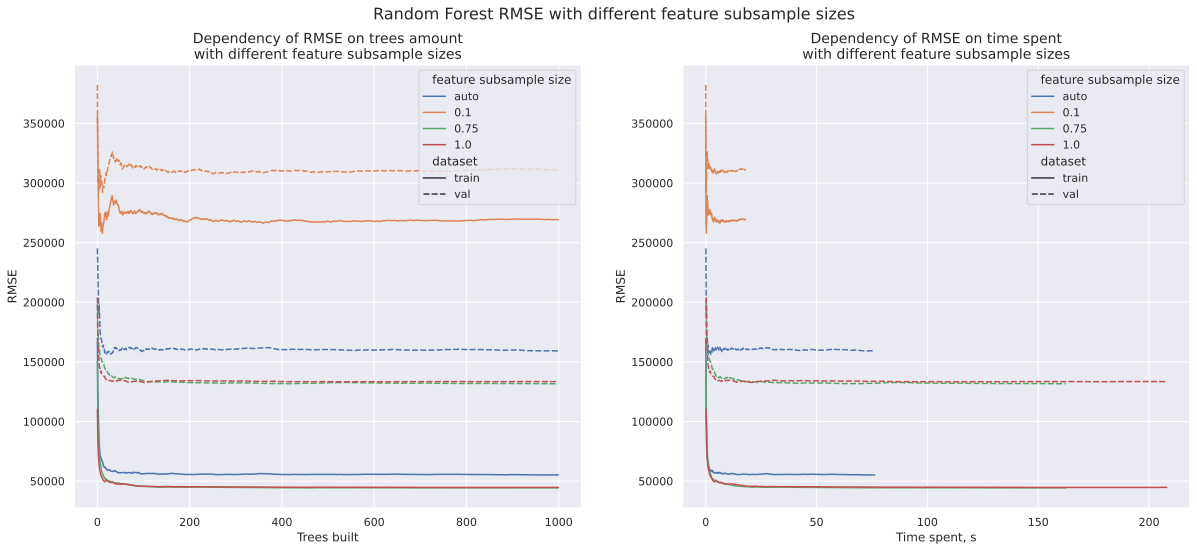

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='feature subsample size', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='feature subsample size', style='dataset', ax=ax[1])

fig.suptitle('Random Forest RMSE with different feature subsample sizes', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different feature subsample sizes', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different feature subsample sizes', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('forest_fss.svg', bbox_inches='tight')

plt.show()

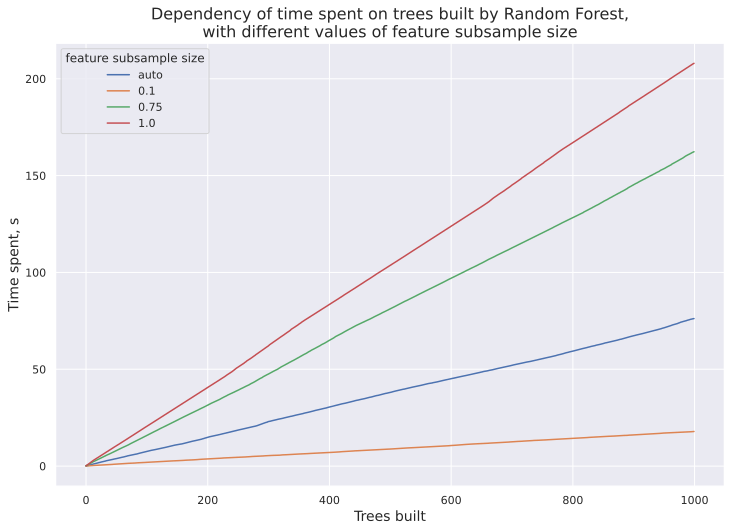

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='feature subsample size')
ax.set_title('Dependency of time spent on trees built by Random Forest,\nwith different values of feature subsample size',
             size=16)
ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('forest_fss_time.svg', bbox_inches='tight')

plt.show()

### max depth

In [26]:
names = list(filter(lambda x: (x[0] == forest_best_params[0]) and (x[2] == forest_best_params[2]), raveled_grid))
names

[(0.75, 1, 1.0), (0.75, 3, 1.0), (0.75, 5, 1.0), (0.75, None, 1.0)]

In [27]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +
                   ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'max depth': str(name[1])
    }) for name in names], axis=0, ignore_index=True)

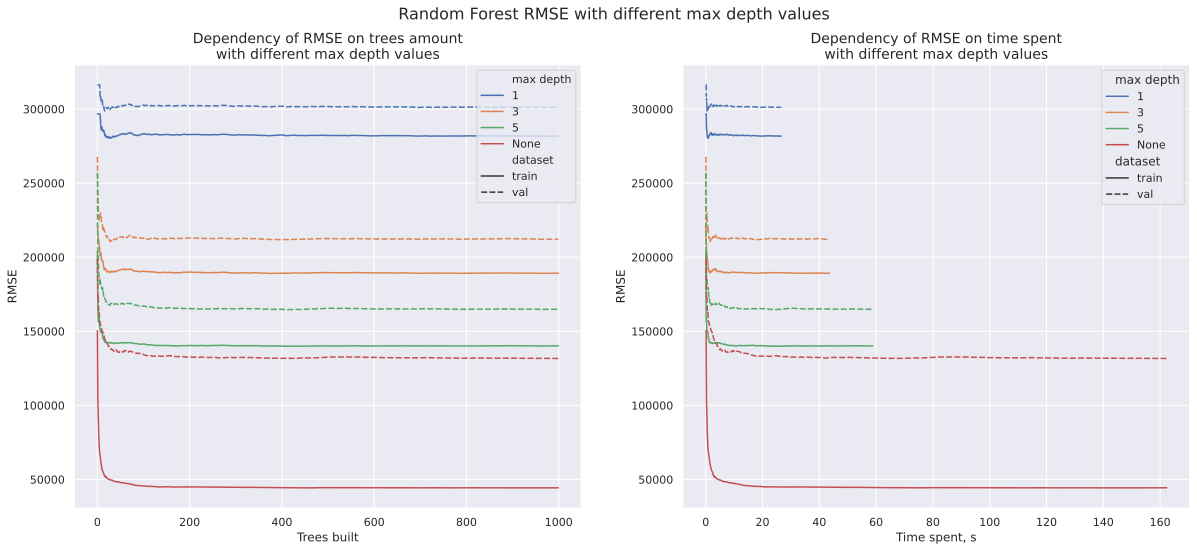

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max depth', style='dataset', ax=ax[0])
ax[0].legend(loc='upper right')
sns.lineplot(data=data, x='time', y='loss', hue='max depth', style='dataset', ax=ax[1])

fig.suptitle('Random Forest RMSE with different max depth values', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different max depth values', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different max depth values', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('forest_md.svg', bbox_inches='tight')
plt.show()

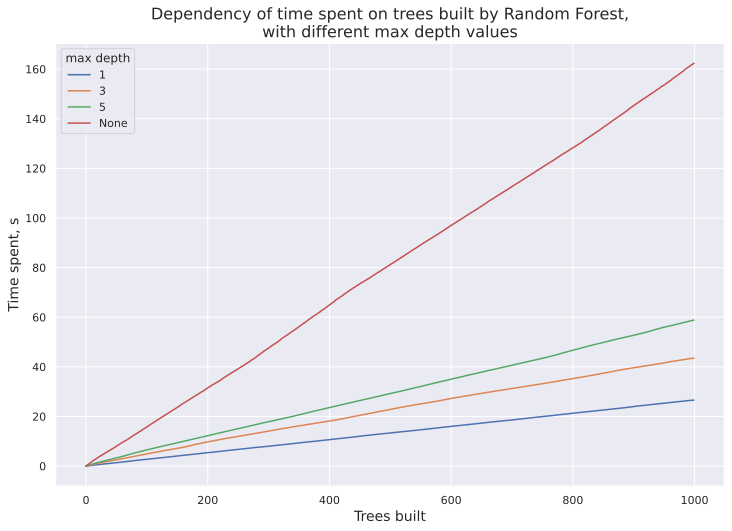

In [29]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='max depth')
ax.set_title('Dependency of time spent on trees built by Random Forest,\nwith different max depth values',
             size=16)
ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('forest_md_time.svg', bbox_inches='tight')
plt.show()

### max samples

In [30]:
names = list(filter(lambda x: (x[0] == forest_best_params[0]) and (x[1] == forest_best_params[1]), raveled_grid))
names

[(0.75, None, 'auto'),
 (0.75, None, 0.3),
 (0.75, None, 0.75),
 (0.75, None, 1.0)]

In [31]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(forest_hist[name]['train loss']))) * 2,
        'loss': np.append(forest_hist[name]['train loss'], forest_hist[name]['val loss']),
        'dataset': ['train'] * len(forest_hist[name]['train loss']) +
                   ['val'] * len(forest_hist[name]['val loss']),
        'time': list(np.cumsum(forest_hist[name]['time'])) * 2,
        'max samples': str(name[2])
    }) for name in names], axis=0, ignore_index=True)

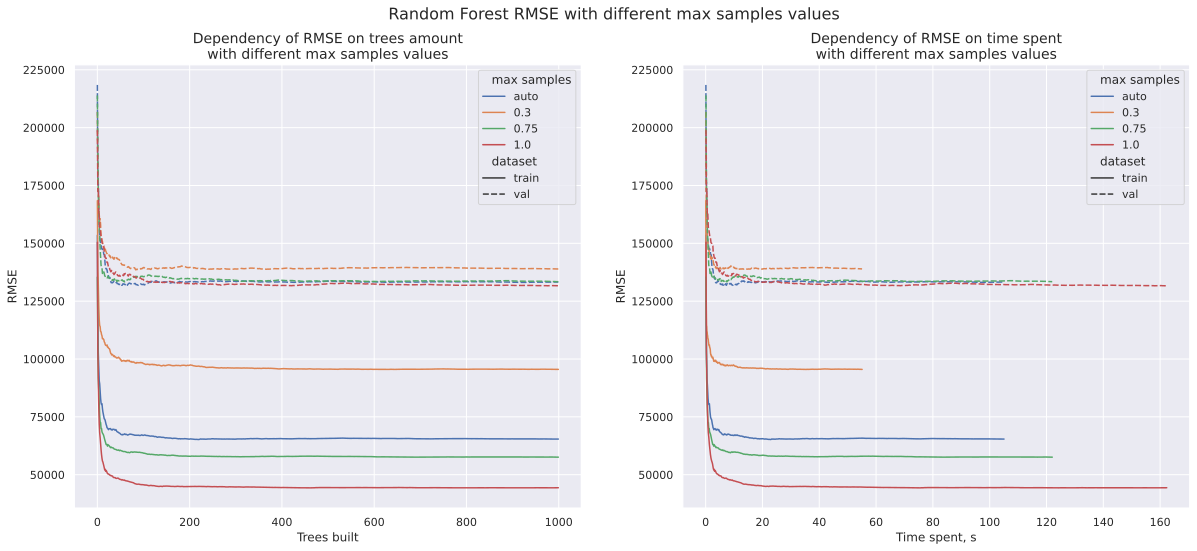

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max samples', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='max samples', style='dataset', ax=ax[1])

fig.suptitle('Random Forest RMSE with different max samples values', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different max samples values', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different max samples values', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('forest_ms.svg', bbox_inches='tight')
plt.show()

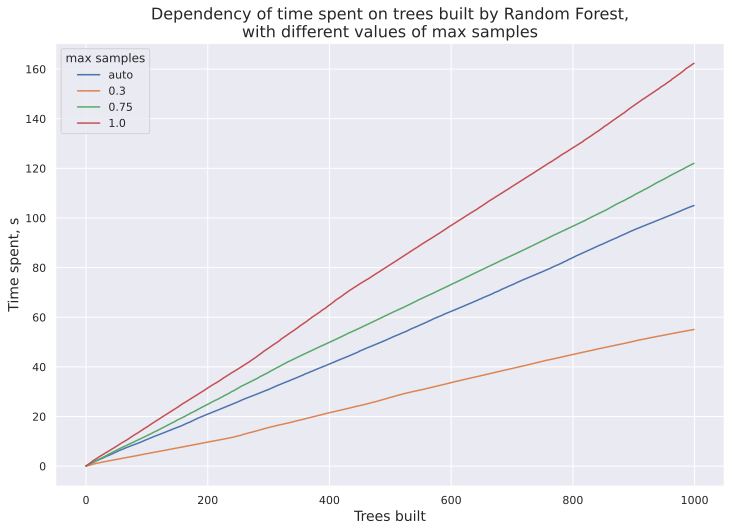

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='max samples')
ax.set_title('Dependency of time spent on trees built by Random Forest,\nwith different values of max samples',
             size=16)
ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('forest_ms_time.svg', bbox_inches='tight')
plt.show()

# Studying the GradientBoosting hyper-parameters

In [42]:
grid = {
    'max_depth': [1, 3, 5, None],
    'learning_rate': [1e-1, 1e0, 1e-2, 1e-3],
    'feature_subsample_size': ['auto', .1, .75, 1.],
    'max_samples': ['auto', .3, .75, 1.],
}

boosting_hist = {}
boosting_best_rmse = None
curr_params = {k: v[0] for k, v in grid.items()}
boosting_best_params = curr_params.copy()
sl = slice(0, None, None)

for param in tqdm(grid.keys()):
    print(f'\nParameter {param}.')
    for param_value in tqdm(grid[param][sl]):
        curr_params[param] = param_value
        model = GradientBoostingMSE(1000, **curr_params,
                                    trace_loss=True, trace_time=True)

        model.fit(X_train, y_train, X_val, y_val)
        curr_rmse = min(model.val_loss_)
        n_estimators = np.argmin(model.val_loss_) + 1
        print(f'Value = {param_value}, score = {curr_rmse}; {n_estimators} trees\n'
              f'\tFull score = {model.score(X_val, y_val, squared=False)}')
        boosting_hist[tuple(curr_params.values())] = {
            'rmse': curr_rmse,
            'train loss': model.train_loss_,
            'val loss': model.val_loss_,
            'trees': n_estimators,
            'time': model.time_spent_
        }
        if (boosting_best_rmse is None) or (curr_rmse < boosting_best_rmse):
            boosting_best_rmse = curr_rmse
            boosting_best_params = curr_params.copy()
    sl = slice(1, None, None)
    print(f'!Best value = {boosting_best_params[param]}, '
          f'Score = {boosting_best_rmse}')
    curr_params[param] = boosting_best_params[param]

  0%|          | 0/4 [00:00<?, ?it/s]


Parameter max_depth.


  0%|          | 0/4 [00:00<?, ?it/s]

Value = 1, score = 165316.178378085; 999 trees
	Full score = 165318.49158946154
Value = 3, score = 128257.22538505177; 984 trees
	Full score = 128299.86347520626
Value = 5, score = 118333.60136827336; 983 trees
	Full score = 118353.45300683341
Value = None, score = 134854.22078615587; 105 trees
	Full score = 135282.53529065335
!Best value = 5, Score = 118333.60136827336

Parameter learning_rate.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 1.0, score = 183867.51914842476; 24 trees
	Full score = 191718.51650353905
Value = 0.01, score = 128135.67882844045; 1000 trees
	Full score = 128135.67882844048
Value = 0.001, score = 217776.4322401139; 1000 trees
	Full score = 217776.4322401139
!Best value = 0.1, Score = 118333.60136827336

Parameter feature_subsample_size.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 0.1, score = 127030.9513070929; 997 trees
	Full score = 127032.37484312398
Value = 0.75, score = 125755.3930457469; 994 trees
	Full score = 125756.91080649244
Value = 1.0, score = 129644.91450941845; 956 trees
	Full score = 129695.8500353159
!Best value = auto, Score = 118333.60136827336

Parameter max_samples.


  0%|          | 0/3 [00:00<?, ?it/s]

Value = 0.3, score = 129785.79262787379; 997 trees
	Full score = 129793.02183276216
Value = 0.75, score = 120452.40285933472; 995 trees
	Full score = 120466.9969326794
Value = 1.0, score = 126235.30376129829; 990 trees
	Full score = 126260.1996112398
!Best value = auto, Score = 118333.60136827336


In [43]:
boosting_best_rmse

118333.60136827336

In [44]:
boosting_best_params = {'max_depth': 5,
                        'learning_rate': 0.1,
                        'feature_subsample_size': 'auto',
                        'max_samples': 'auto'}

In [45]:
boosting_best_params

{'max_depth': 5,
 'learning_rate': 0.1,
 'feature_subsample_size': 'auto',
 'max_samples': 'auto'}

In [46]:
if True:
    with open('boosting_hist', 'wb') as f:
        pickle.dump(boosting_hist, f)

In [47]:
with open('boosting_hist', 'rb') as f:
    boosting_hist = pickle.load(f)

In [48]:
keys = list(boosting_hist.keys())

In [49]:
pd.concat((pd.DataFrame({
    'params': [key],
    'time': sum(boosting_hist[key]['time']),
    'trees': boosting_hist[key]['trees'],
    'train_rmse': min(boosting_hist[key]['train loss']),
    'val_rmse': min(boosting_hist[key]['val loss']),
}) for key in keys), ignore_index=True).T

,0,1,2,3,4,5,6,7,8,9,10,11,12
params,"(1, 0.1, auto, auto)","(3, 0.1, auto, auto)","(5, 0.1, auto, auto)","(None, 0.1, auto, auto)","(5, 1.0, auto, auto)","(5, 0.01, auto, auto)","(5, 0.001, auto, auto)","(5, 0.1, 0.1, auto)","(5, 0.1, 0.75, auto)","(5, 0.1, 1.0, auto)","(5, 0.1, auto, 0.3)","(5, 0.1, auto, 0.75)","(5, 0.1, auto, 1.0)"
time,3.469088,7.265985,11.124344,107.748057,11.617191,11.47154,11.194419,3.265673,24.552795,32.714528,6.088226,13.390715,17.114064
trees,999,984,983,105,24,1000,1000,997,994,956,997,995,990
train_rmse,133222.185385,84824.738272,59583.649712,0.955013,25226.183137,91297.070109,198328.509346,72123.748815,56920.992971,55757.483464,73940.491414,56413.79938,53056.349474
val_rmse,165316.178378,128257.225385,118333.601368,134854.220786,183867.519148,128135.678828,217776.43224,127030.951307,125755.393046,129644.914509,129785.792628,120452.402859,126235.303761


### max_depth

In [50]:
names = keys[:4]
names

[(1, 0.1, 'auto', 'auto'),
 (3, 0.1, 'auto', 'auto'),
 (5, 0.1, 'auto', 'auto'),
 (None, 0.1, 'auto', 'auto')]

In [51]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +\
                ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'max depth': str(name[0])
    }) for name in names], axis=0, ignore_index=True)

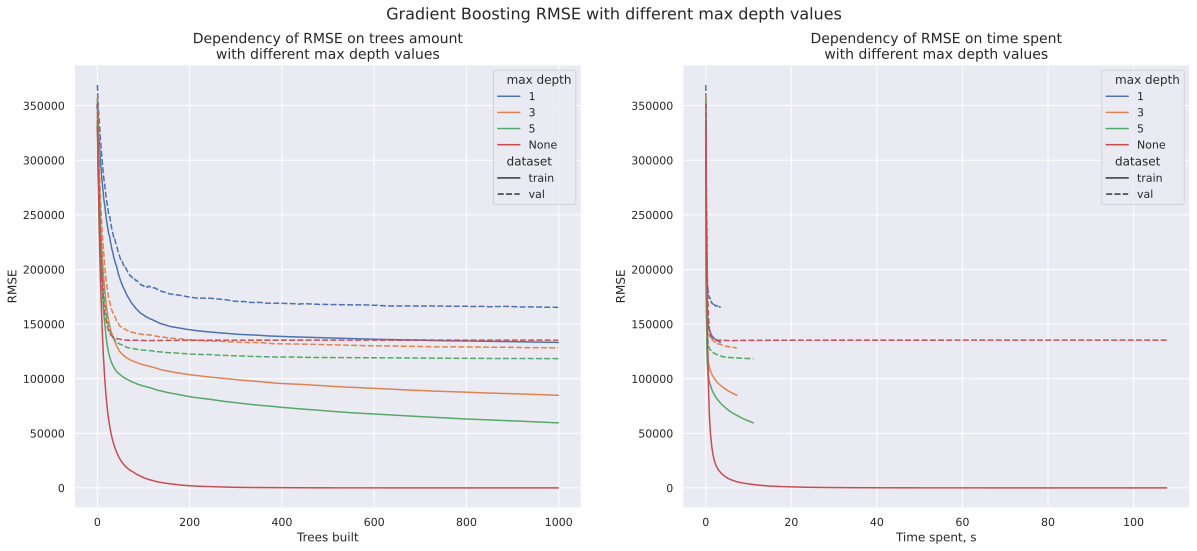

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max depth', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='max depth', style='dataset', ax=ax[1])

fig.suptitle('Gradient Boosting RMSE with different max depth values', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different max depth values', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different max depth values', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('gradient_boosting_md.svg', bbox_inches='tight')
plt.show()

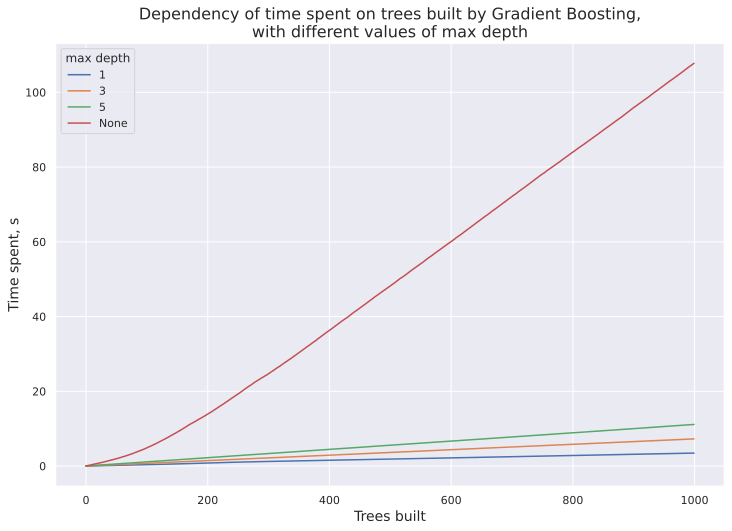

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='max depth')
ax.set_title('Dependency of time spent on trees built by Gradient Boosting,\nwith different values of max depth', size=16)
ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('boosting_md_time.svg', bbox_inches='tight')
plt.show()

### learning rate

In [54]:
names = keys[2:3] + keys[4:7]
names

[(5, 0.1, 'auto', 'auto'),
 (5, 1.0, 'auto', 'auto'),
 (5, 0.01, 'auto', 'auto'),
 (5, 0.001, 'auto', 'auto')]

In [55]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'learning rate': str(name[1])
    }) for name in names], axis=0, ignore_index=True)

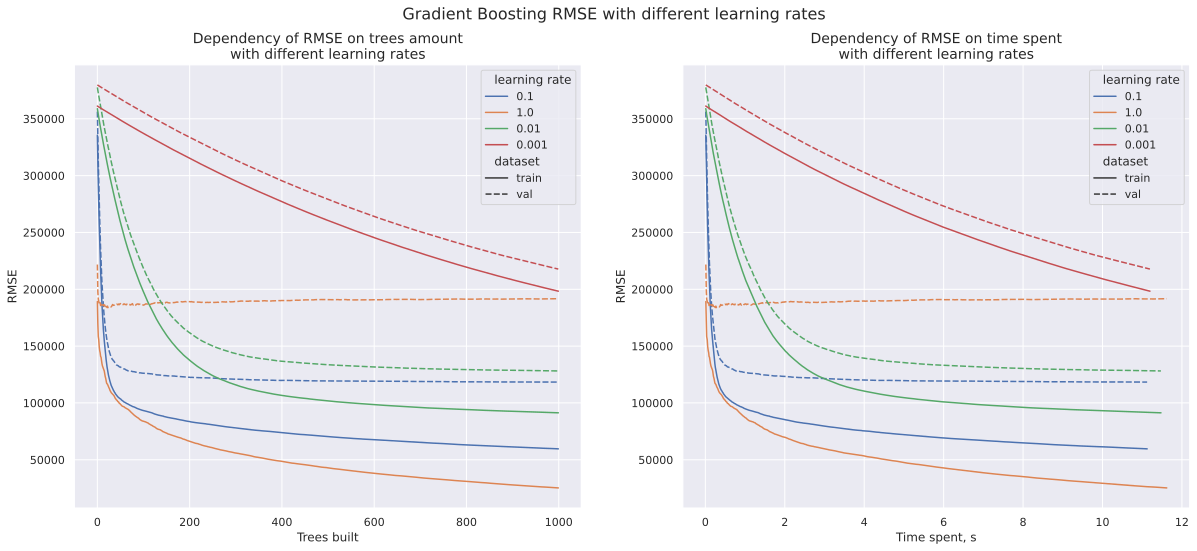

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='learning rate', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='learning rate', style='dataset', ax=ax[1])

fig.suptitle('Gradient Boosting RMSE with different learning rates', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different learning rates', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different learning rates', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('gradient_boosting_lr.svg', bbox_inches='tight')
plt.show()

### feature subsample size

In [57]:
names = keys[2:3] + keys[7:10]
names

[(5, 0.1, 'auto', 'auto'),
 (5, 0.1, 0.1, 'auto'),
 (5, 0.1, 0.75, 'auto'),
 (5, 0.1, 1.0, 'auto')]

In [58]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'feature subsample size': str(name[2])
    }) for name in names], axis=0, ignore_index=True)

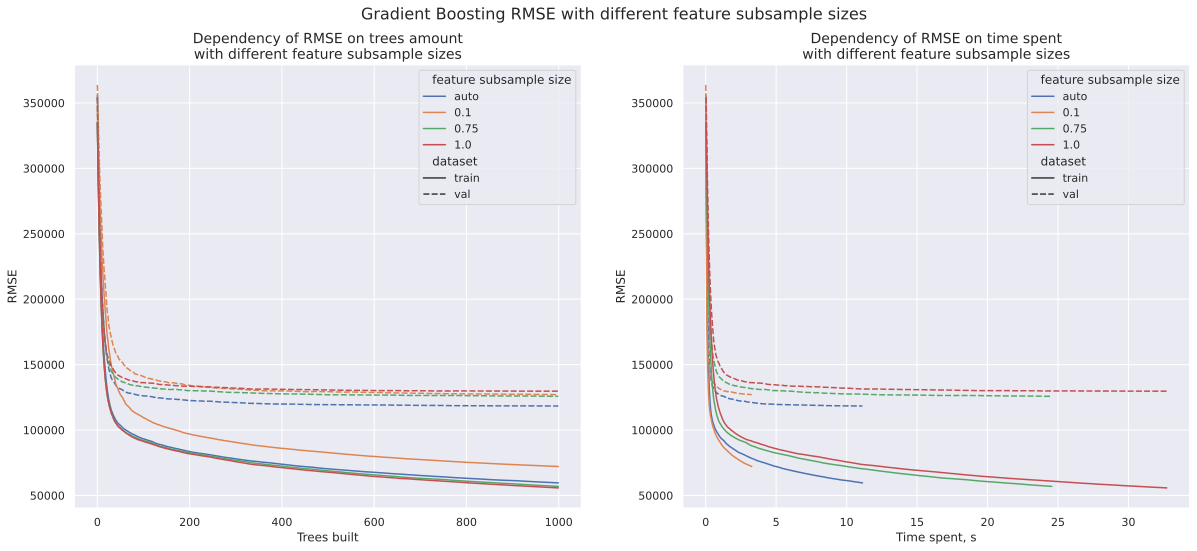

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='feature subsample size', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='feature subsample size', style='dataset', ax=ax[1])

fig.suptitle('Gradient Boosting RMSE with different feature subsample sizes', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different feature subsample sizes', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different feature subsample sizes', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('gradient_boosting_fss.svg', bbox_inches='tight')
plt.show()

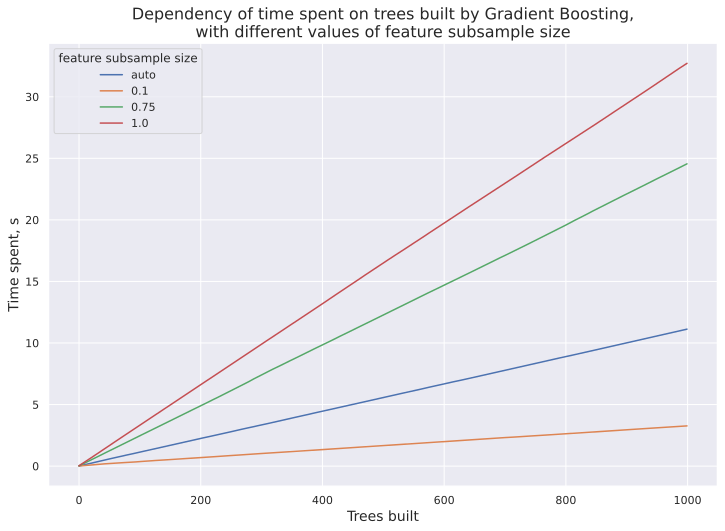

In [60]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='feature subsample size')
ax.set_title('Dependency of time spent on trees built by Gradient Boosting,\nwith different values of feature subsample size',
             size=16)

ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('boosting_fss_time.svg', bbox_inches='tight')
plt.show()

### max samples

In [64]:
names = keys[2:3] + keys[10:]
names

[(5, 0.1, 'auto', 'auto'),
 (5, 0.1, 'auto', 0.3),
 (5, 0.1, 'auto', 0.75),
 (5, 0.1, 'auto', 1.0)]

In [65]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(boosting_hist[name]['train loss']))) * 2,
        'loss': np.append(boosting_hist[name]['train loss'], boosting_hist[name]['val loss']),
        'dataset': ['train'] * len(boosting_hist[name]['train loss']) +
                   ['val'] * len(boosting_hist[name]['val loss']),
        'time': list(np.cumsum(boosting_hist[name]['time'])) * 2,
        'max samples': str(name[-1])
    }) for name in names], axis=0, ignore_index=True)

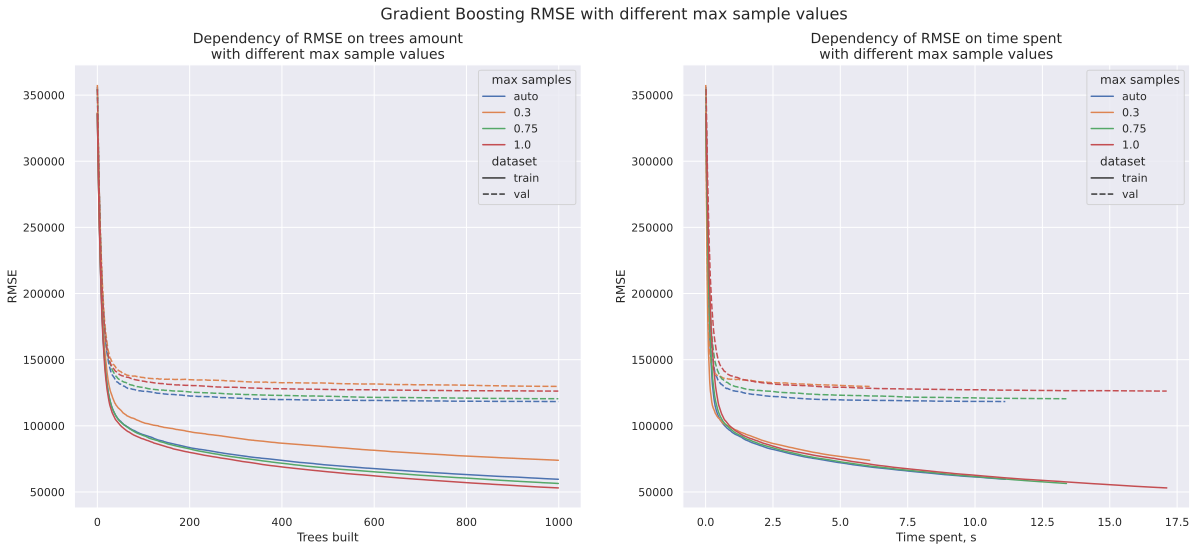

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='max samples', style='dataset', ax=ax[0])
sns.lineplot(data=data, x='time', y='loss', hue='max samples', style='dataset', ax=ax[1])

fig.suptitle('Gradient Boosting RMSE with different max sample values', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nwith different max sample values', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nwith different max sample values', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('gradient_boosting_ms.svg', bbox_inches='tight')
plt.show()

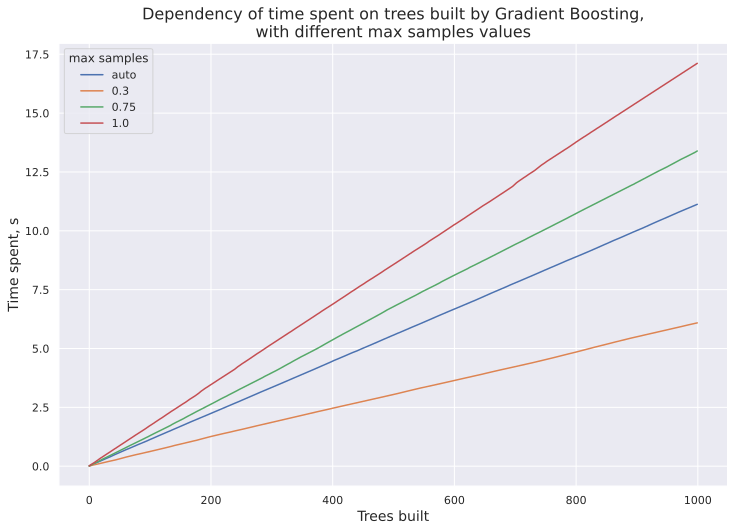

In [67]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time', hue='max samples')
ax.set_title('Dependency of time spent on trees built by Gradient Boosting,\nwith different max samples values',
             size=16)

ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('boosting_ms_time.svg', bbox_inches='tight')
plt.show()

# Comparison of algorithms

In [74]:
forest_best_params_d = dict(zip(param_names, forest_best_params))

In [75]:
best_forest = RandomForestMSE(
    1000,
    **forest_best_params_d,
    n_jobs=1,
    trace_loss=True,
    trace_time=True
).fit(X_train, y_train, X_val, y_val)

best_boosting = GradientBoostingMSE(
    1000,
    **boosting_best_params,
    trace_loss=True,
    trace_time=True
).fit(X_train, y_train, X_val, y_val)

In [76]:
data = pd.concat(
    [pd.DataFrame({
        'trees': list(np.arange(len(algorithm.train_loss_))) * 2,
        'loss': np.append(algorithm.train_loss_, algorithm.val_loss_),
        'dataset': ['train'] * len(algorithm.train_loss_) +
                   ['val'] * len(algorithm.val_loss_),
        'time': list(np.cumsum(algorithm.time_spent_)) * 2,
        'algorithm': alg_name
    }) for algorithm, alg_name in zip(
        (best_forest, best_boosting),
        ('RandomForest', 'GradientBoosting')
    )],
    axis=0,
    ignore_index=True
)

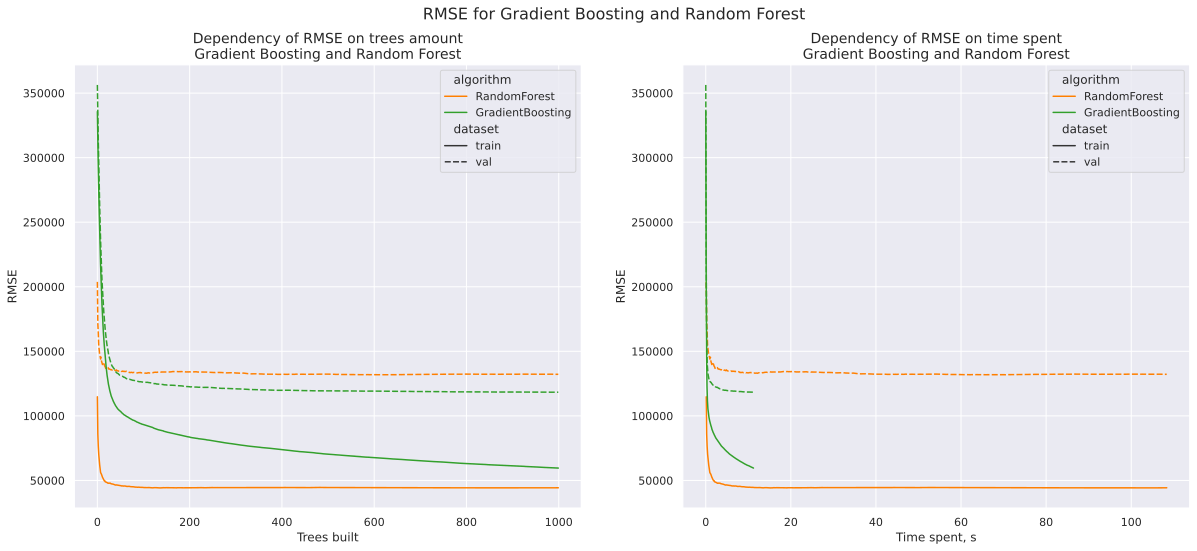

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

sns.lineplot(data=data, x='trees', y='loss', hue='algorithm', style='dataset',
             ax=ax[0], palette='Paired_r')
sns.lineplot(data=data, x='time', y='loss', hue='algorithm', style='dataset',
             ax=ax[1], palette='Paired_r')
fig.suptitle('RMSE for Gradient Boosting and Random Forest', fontsize=16)
ax[0].set_title('Dependency of RMSE on trees amount\nGradient Boosting and Random Forest', size=14)
ax[1].set_title('Dependency of RMSE on time spent\nGradient Boosting and Random Forest', size=14)
ax[0].set_xlabel('Trees built', size=12)
ax[0].set_ylabel('RMSE', size=12)

ax[1].set_xlabel('Time spent, s', size=12)
ax[1].set_ylabel('RMSE', size=12)

fig.savefig('gb_vs_rf.svg', bbox_inches='tight')
plt.show()

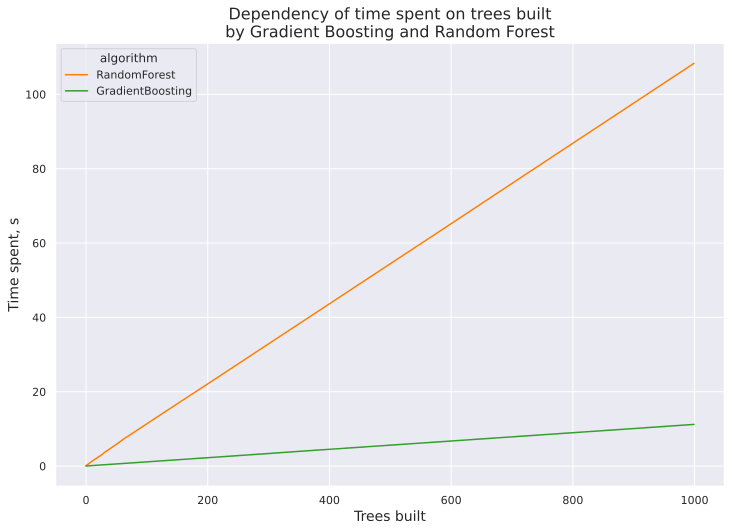

In [88]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(data=data.loc[data['dataset'] == 'train', :], x='trees', y='time',
             hue='algorithm', palette='Paired_r')
ax.set_title('Dependency of time spent on trees built\nby Gradient Boosting and Random Forest',
             size=16)

ax.set_xlabel('Trees built', size=14)
ax.set_ylabel('Time spent, s', size=14)
fig.savefig('gb_vs_rf_time.svg', bbox_inches='tight')
plt.show()

In [91]:
t = time.time()

best_forest = RandomForestMSE(
    1000,
    **forest_best_params_d,
    n_jobs=-1,
    trace_loss=True,
    trace_time=True
).fit(X_train, y_train, X_val, y_val)

t = time.time() - t

print(f'Time spent by parallelized Random forest = {t: .2f} s')

t = time.time()

best_boosting = GradientBoostingMSE(
    1000,
    **boosting_best_params,
    trace_loss=True,
    trace_time=True
).fit(X_train, y_train, X_val, y_val)

t = time.time() - t

print(f'Time spent by Gradient Boosting = {t: .2f} s')

Time spent by parallelized Random forest =  15.67 s
Time spent by Gradient Boosting =  15.14 s
